## Урок 8. Снижение размерности данных

#### Задание 1. 

Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

#### Задание 2.

Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data

In [3]:
# Для начала отмасштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

#### Задание 1:

In [4]:
U, s, W = np.linalg.svd(X_)
print(s)
print(W)

[20.92306556 11.7091661   4.69185798  1.76273239]
[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [-0.37741762 -0.92329566 -0.02449161 -0.06694199]
 [ 0.71956635 -0.24438178 -0.14212637 -0.63427274]
 [ 0.26128628 -0.12350962 -0.80144925  0.52359713]]


Строки матрицы W являются собственными векторами, соответствующими сингулярным числам из множества s. Возьмем для преобразования только первые строки

In [5]:
Z = X_ @ W[:2,:].T

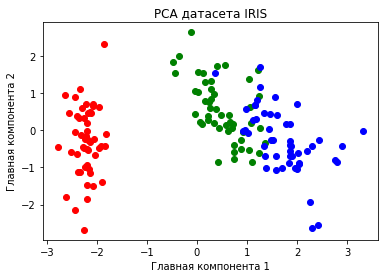

In [6]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

Как видно, снижение размерности данных через сингулярное разложение матриц абсолютно идентично снижению размерности через собственные вектора и собственные значения матрицы ковариации.

#### Задание 2:

In [7]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
        
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        
    

class DTC:
    
    def __init__(self, min_leaf=1, criterion='gini', max_depth=None, max_leaf_count=None):
        self.min_leaf = min_leaf
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_leaf_count = max_leaf_count 
        self._tree = None # дерево решений
        self.tasks = [] # список задач для создания дерева 'сначала вширь'
        self.nodes = [{ # список узлов для создания дерева 'сначала вширь'
            'id_': 0,
            'parent_id': None,
            't': None,
            'index': None,
            'is_left': None,
            'is_node': True
        }]
        self.leaf_count = 0 # счетчик листьев
        
    
    def _criterion(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        if self.criterion == 'gini':
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p ** 2
        elif self.criterion == 'shannon':
            impurity = 0
            for label in classes:
                p = classes[label] / len(labels)
                part = p * np.log2(p) if p else 0
                impurity -= part

        return impurity  
    
    
    def _quality(self, left_labels, right_labels, current_criterion):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_criterion - p * self._criterion(left_labels) - (1 - p) * self._criterion(right_labels)

    
    def _split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    
    def _find_best_split(self, data, labels):

        current_criterion = self._criterion(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, current_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    
    def _build_tree(self, data, labels, level=0, id_=0):

        quality, t, index = self._find_best_split(data, labels)
        
        # Проверяем, что сумма количества листьев и узлов в списке вместе с текущей задачей меньше self.max_leaf_count:
        if self.max_leaf_count is not None:
            max_leaf_flag = False if self.leaf_count + len(self.tasks) + 1 < self.max_leaf_count else True
        else:
            max_leaf_flag = False

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества или дерево достигло максимальной глубины,
        # или количество листьев больше или равно максимальному
        if quality == 0 or level == self.max_depth or max_leaf_flag:
            self.leaf_count += 1
            for itm in self.nodes:
                if itm['id_'] == id_:
                    itm['is_node'] = False
                    itm['data'] = data
                    itm['labels'] = labels
            if len(self.tasks):
                self._build_tree(*self.tasks.pop(0))
        else:
            true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
            for itm in self.nodes:
                if itm['id_'] == id_:
                    itm['t'] = t
                    itm['index'] = index

            # Добавляем в список задач и список узлов две ветки поддерева
            level += 1
            current_len = len(self.nodes)
            self.tasks.append([true_data, true_labels, level, current_len])
            self.tasks.append([false_data, false_labels, level, current_len + 1])
            self.nodes.append({
                'id_': current_len,
                'parent_id': id_,
                't': None,
                'index': None,
                'is_left': True,
                'is_node': True
            })
            self.nodes.append({
                'id_': current_len + 1,
                'parent_id': id_,
                't': None,
                'index': None,
                'is_left': False,
                'is_node': True
            })


            self._build_tree(*self.tasks.pop(0))

    
    def _create_instance(self, id_=0): # функция создания дерева по списку узлов self.nodes
        for itm in self.nodes:
            if itm['id_'] == id_:
                if itm['is_node']:
                    index = itm['index']
                    t = itm['t']
                    break
                else:
                    return Leaf(itm['data'], itm['labels'])
        for itm in self.nodes:
            if itm['parent_id'] == id_ and itm['is_left']:
                true_branch = self._create_instance(itm['id_'])
            if itm['parent_id'] == id_ and not itm['is_left']:
                false_branch = self._create_instance(itm['id_'])
        
        return Node(index, t, true_branch, false_branch)
    
    
    def fit(self, data, labels):
        self._build_tree(data, labels, 0, 0)
        self._tree = self._create_instance()
        
        
    def _classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)
    
    
    def predict(self, data):

        classes = []
        for obj in data:
            prediction = self._classify_object(obj, self._tree)
            classes.append(prediction)
        return classes
    
    
    def print_tree(self):
        node = self._tree
        self._print_nodes(node)
    
    
    def _print_nodes(self, node, spacing=""):

        # Если лист, то выводим его прогноз
        if isinstance(node, Leaf):
            print(spacing + "Прогноз:", node.prediction)
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index))
        print(spacing + 'Порог', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> True:')
        self._print_nodes(node.true_branch, spacing + "  ")

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> False:')
        self._print_nodes(node.false_branch, spacing + "  ")

        

Разделим оригинальную отмасштабированную выборку на трейн и тест:

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [11]:
def draw_hypreparameters(train_accuracy, test_accuracy, xlabel, ylabel):
    plt.figure(figsize = (16, 7))
    plt.plot(range(1, len(train_accuracy)+1), train_accuracy, label='train')
    plt.plot(range(1, len(train_accuracy)+1), test_accuracy, label='test')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

Подберем гиперпараметры для модели:

In [12]:
train_accuracy = []
test_accuracy = []
for itm in range(1, 11):
    dtc = DTC(min_leaf=itm)
    dtc.fit(X_train, y_train)
    train_answers = dtc.predict(X_train)
    answers = dtc.predict(X_test)
    train_accuracy.append(accuracy_metric(y_train, train_answers))
    test_accuracy.append(accuracy_metric(y_test, answers))

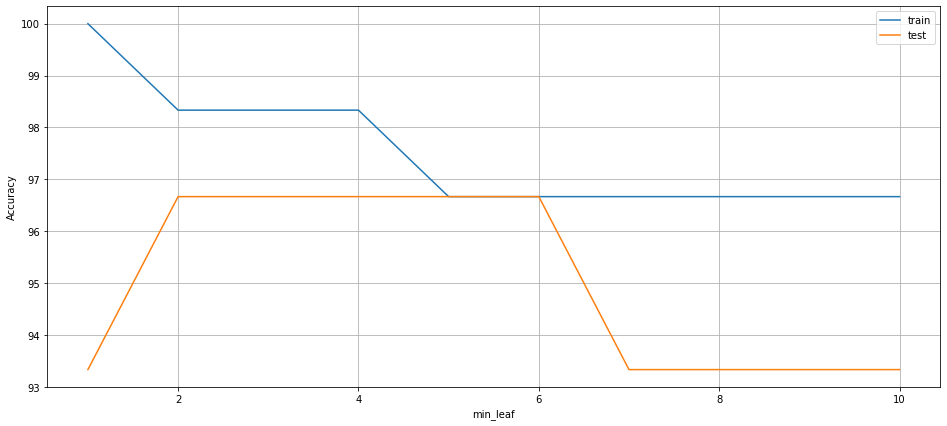

In [13]:
draw_hypreparameters(train_accuracy, test_accuracy, 'min_leaf', 'Accuracy')

In [14]:
train_accuracy = []
test_accuracy = []
for itm in range(1, 11):
    dtc = DTC(max_depth=itm)
    dtc.fit(X_train, y_train)
    train_answers = dtc.predict(X_train)
    answers = dtc.predict(X_test)
    train_accuracy.append(accuracy_metric(y_train, train_answers))
    test_accuracy.append(accuracy_metric(y_test, answers))

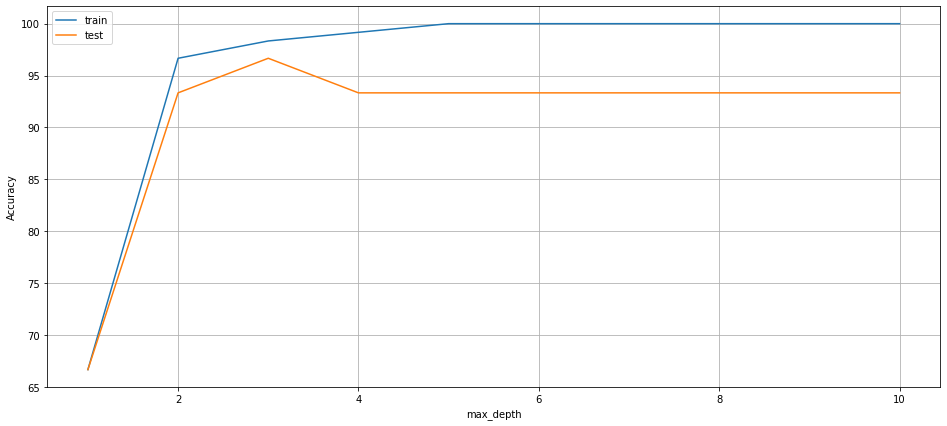

In [15]:
draw_hypreparameters(train_accuracy, test_accuracy, 'max_depth', 'Accuracy')

Обучим модель:

In [16]:
simple_futures_model = DTC(min_leaf=5)
simple_futures_model.fit(X_train, y_train)
train_answers = simple_futures_model.predict(X_train)
answers = simple_futures_model.predict(X_test)
print(accuracy_metric(y_train, train_answers))
print(accuracy_metric(y_test, answers))

96.66666666666667
96.66666666666667


Получили очень высокую метрику классификации. Теперь проделаем все то же самое для датасета со сниженной размерностью данных:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
train_accuracy = []
test_accuracy = []
for itm in range(1, 11):
    dtc = DTC(min_leaf=itm)
    dtc.fit(X_train, y_train)
    train_answers = dtc.predict(X_train)
    answers = dtc.predict(X_test)
    train_accuracy.append(accuracy_metric(y_train, train_answers))
    test_accuracy.append(accuracy_metric(y_test, answers))

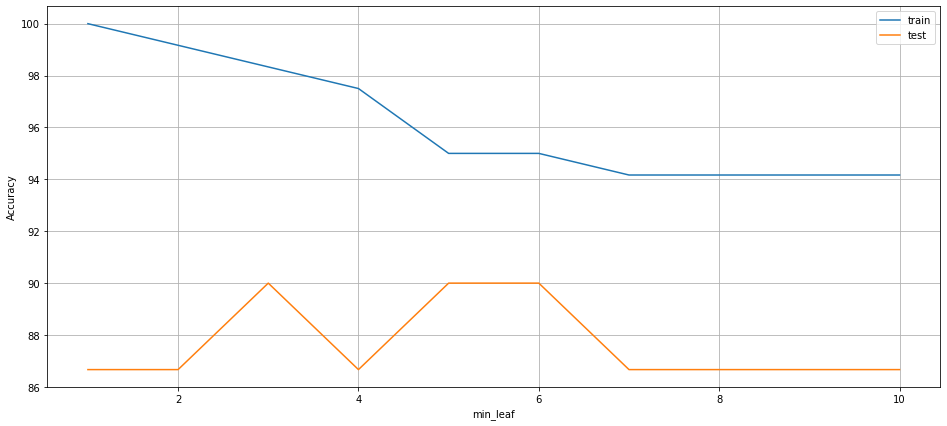

In [19]:
draw_hypreparameters(train_accuracy, test_accuracy, 'min_leaf', 'Accuracy')

In [20]:
train_accuracy = []
test_accuracy = []
for itm in range(1, 11):
    dtc = DTC(max_depth=itm)
    dtc.fit(X_train, y_train)
    train_answers = dtc.predict(X_train)
    answers = dtc.predict(X_test)
    train_accuracy.append(accuracy_metric(y_train, train_answers))
    test_accuracy.append(accuracy_metric(y_test, answers))

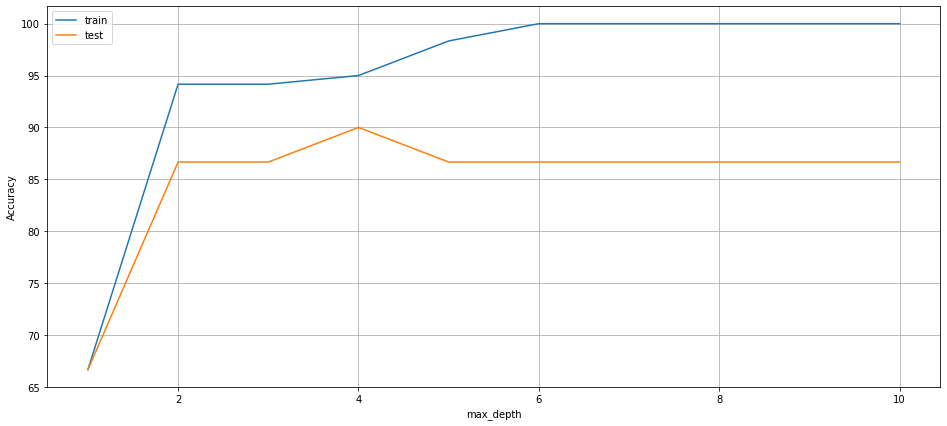

In [21]:
draw_hypreparameters(train_accuracy, test_accuracy, 'max_depth', 'Accuracy')

In [22]:
PCA_futures_model = DTC(min_leaf=5)
PCA_futures_model.fit(X_train, y_train)
train_answers = PCA_futures_model.predict(X_train)
answers = PCA_futures_model.predict(X_test)
print(accuracy_metric(y_train, train_answers))
print(accuracy_metric(y_test, answers))

95.0
90.0


Как видно, качество метрики на трейне и тесте немного упало, но метрика все равно осталась высокой. Собственно, при понижении размерности, куммулятивноя доля дисперсии описываемая первыми двумя главными компонентами, составляет около 95%. Поэтому нельзя было ожидать повышения качества работы модели при понижении размерности. Но главное при этом, что метрика качества осталась достаточно высока. При очень большом количестве признаков такое снижение размерности может быть очень полезным.